# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Skillfactory---Практический-Machine-Learning" data-toc-modified-id="Skillfactory---Практический-Machine-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Skillfactory - Практический Machine Learning</a></div><div class="lev2 toc-item"><a href="#19/02/2018---Аномалии,-работа-с-признаками,-пайплайны-(практика)" data-toc-modified-id="19/02/2018---Аномалии,-работа-с-признаками,-пайплайны-(практика)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>19/02/2018 - Аномалии, работа с признаками, пайплайны (практика)</a></div><div class="lev2 toc-item"><a href="#Hyperparameter-Search" data-toc-modified-id="Hyperparameter-Search-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Hyperparameter Search</a></div><div class="lev2 toc-item"><a href="#Небольшая-предобработка" data-toc-modified-id="Небольшая-предобработка-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Небольшая предобработка</a></div><div class="lev1 toc-item"><a href="#Pipeline" data-toc-modified-id="Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pipeline</a></div><div class="lev3 toc-item"><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-201"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></div><div class="lev1 toc-item"><a href="#HyperOpt" data-toc-modified-id="HyperOpt-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HyperOpt</a></div>

# Skillfactory - Практический Machine Learning
## 19/02/2018 - Аномалии, работа с признаками, пайплайны (практика)

<center> Шестаков Андрей </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def load_otp():
    features = pd.read_csv('data/descr.txt', sep='\t', encoding='cp1251', names=['feature', 'descr'])
    
    features = features.iloc[3:]
    feature_names = features.iloc[:, 0].values
    
    df_data_x = pd.read_csv('data/data_x.csv', sep=';', header=None, names=feature_names)
    df_data_x.loc[:, 'PREVIOUS_CARD_NUM_UTILIZED'] = df_data_x.PREVIOUS_CARD_NUM_UTILIZED.fillna(0)
    
    features.loc[:, 'uniq_vals'] = df_data_x.apply(lambda c: c.nunique(), axis=0).values
    
    features = features.reset_index(drop=True)
    
    df_data_y = pd.read_csv('data/data_y.csv', sep=';', names=['active'])
    
    idx = np.where(df_data_x.dtypes == 'object')[0]

    for i in idx:
        df_data_x.iloc[:, i] = df_data_x.iloc[:, i].str.replace(',', '.').astype('float')
        
    df_data = df_data_x.join(df_data_y)
    
    return df_data, features

## Hyperparameter Search

Давайте для задачи по ОТП сделаем end-to-end pipeline

<img src='img/pipeline.png'>

In [3]:
df, features = load_otp()

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(predictions, yval):
    try:
        preds = predictions[:,1]
    except:
        preds = np.array(predictions)
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white',
                     'axes.labelcolor':'white'}):
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [5]:
RND_SEED = 123

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_idx):
        self.col_idx = col_idx
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.col_idx]

In [7]:
cat_features = [6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 33]
binary_features = features[features.uniq_vals == 2].index.values
cont_features = np.setdiff1d(np.arange(50), cat_features)
cont_features = np.setdiff1d(cont_features, binary_features)

### Подбор гиперпараметров

<img src='img/gridsearch.jpeg'>

In [8]:
from scipy.stats import randint as sp_randint

X = df.iloc[:, :-1].fillna(0)
y = df.iloc[:, -1].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.shape, X_test.shape

((10656, 50), (4567, 50))

In [10]:
model = LogisticRegression()
param_grid = { "penalty"      : ['l1', 'l2'],
               "C"      : np.linspace(0.00001, 100, 1),
               "class_weight"         : [None, 'balanced']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

model = LogisticRegression(**grid_search.best_params_)
model.fit(X_train, y_train)

{'C': 1e-05, 'class_weight': 'balanced', 'penalty': 'l2'}


LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

/Users/dmitrys/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


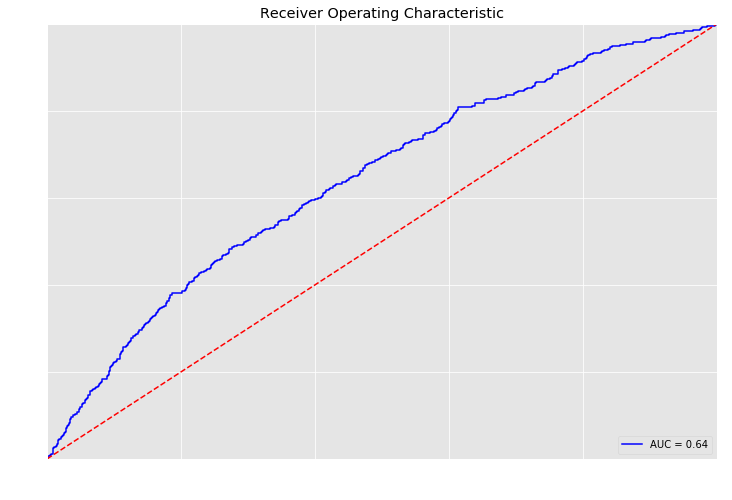

In [11]:
plot_roc_curve(model.predict_proba(X_test), y_test)

# HyperOpt

In [12]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, rand
from sklearn.model_selection import cross_val_score

In [13]:
# sudo pip install networkx==1.11

In [14]:
trials = Trials()
best = fmin(
    fn=lambda x: (x-1)**2,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

{'x': 1.000279358008066}


In [15]:
def trials_df(trials):
    '''
    Функция форматирует результаты hyperopt в dataframe
    '''
    tr_dict = []
    for t in trials:
        trial = dict()
        for k, v in t['misc']['vals'].items():
            trial[k] = v[0]

        trial['qscore'] = -t['result']['qscore']
        trial['qscore_std'] = -t['result']['qscore_std']
        tr_dict.append(trial)

    df_res = pd.DataFrame.from_dict(tr_dict)
    df_res = df_res.sort_values('qscore', ascending=False)
    
    return df_res

In [16]:
def run_trials_template(X, y, params, evals=100):

    def hyperopt_cv(X, y, params):
        
        X_ = X.copy()
        
        # set params
        lm_params = {}
        tfidf_params = {}
        for k, v in params.items():
            if k.startswith('glob'):
                continue                
            elif k.startswith('lm'):
                lm_params[k.split('_', 1)[1]] = v
            
        model = LogisticRegression(**lm_params)

        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, 
                             random_state=RND_SEED)
        scores = cross_val_score(model, X_, y,
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=5)

        return scores.mean(), scores.std()

    def f(params):
        acc, std = hyperopt_cv(X, y, params)
        return {'loss': -acc, 'qscore': -acc, 'qscore_std': std, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, 
                params, 
                algo=rand.suggest, 
                max_evals=evals, 
                trials=trials, 
                verbose=0)
    
    return trials

In [ ]:
space4_lm = {
    'lm_penalty': hp.choice('penalty', ['l1', 'l2']),
    'lm_C': hp.loguniform('C', -5, 3),
    'lm_class_weight': hp.choice('class_weight', [None, 'balanced']),
    'lm_random_state': RND_SEED,
}

In [ ]:
trials = run_trials_template(X_train, y_train, space4_lm, evals=100)
    
df_trials = trials_df(trials) 

In [ ]:
df_trials.sort_values(by='qscore', ascending=False).head(10)

In [ ]:
optimal = df_trials.sort_values(by='qscore', ascending=False).iloc[0]

In [ ]:
optimal

In [ ]:
model_opt = LogisticRegression(C = optimal.C, 
                               class_weight=[None, 'balanced'][int(optimal.class_weight)], 
                               penalty=['l1', 'l2'][int(optimal.penalty)])
model_opt.fit(X_train, y_train)

plot_roc_curve(model_opt.predict_proba(X_test), y_test)

In [ ]:
df_trials.sort_values(by='qscore', ascending=False).iloc[0]

In [ ]:
df_trials.plot.scatter('C', 'qscore')